## Project 3: Trading Bot

### Prompt

*"You've just determined a winning stock market trading strategy. The problem? It requires you to make trades extremely precisely -- with little room for error. Build your own algorithmic trading bot -- capable of responding to incoming market data in real-time."*

### Approach

I'm going to recreate [this notebook](https://github.com/ORE93/Automated-Algorithmic-Trading-Bot/blob/main/Algo_trade.ipynb) and then see if I can improve on their results. Their solution relies on the [Alpaca trade API](https://docs.alpaca.markets/docs/getting-started-with-trading-api), which in turn relies on Python 3.10, so I switched to a new virtual environment using [Miniconda](https://docs.conda.io/en/latest/miniconda.html) and [these packages](./requirements-310.txt).

In [11]:
import pandas
import numpy
import json
import seaborn
import matplotlib.pyplot as matplot
from matplotlib.dates import DayLocator
# from alpaca.trading.client import TradingClient
from alpaca.data.historical import StockHistoricalDataClient #, CryptoHistoricalDataClient
from alpaca.data.requests import StockBarsRequest #, CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
from finta import TA

In [12]:
with open('./api/alpaca-paper.json') as keyfile: api = json.load(keyfile)
data_client = StockHistoricalDataClient(api['KEY'], api['SECRET'])
# trade_client = TradingClient(api['KEY'], api['SECRET'], paper=True)

In [13]:
data_req = StockBarsRequest(symbol_or_symbols='X', timeframe=TimeFrame.Day, start=datetime(2023, 1, 1), end=datetime(2023, 3, 31))
hist_data = data_client.get_stock_bars(data_req).df
hist_data

open     high    low  close     volume  \
symbol timestamp                                                            
X      2023-01-03 05:00:00+00:00  25.30  25.7700  24.84  25.04  5294483.0   
       2023-01-04 05:00:00+00:00  24.77  25.5000  24.33  25.23  6494526.0   
       2023-01-05 05:00:00+00:00  25.11  25.6900  24.57  25.45  5754605.0   
       2023-01-06 05:00:00+00:00  25.84  26.9399  25.77  26.90  7629539.0   
       2023-01-09 05:00:00+00:00  27.33  27.3900  26.45  26.47  5452554.0   
...                                 ...      ...    ...    ...        ...   
       2023-03-24 04:00:00+00:00  24.51  25.1000  23.95  25.00  8125204.0   
       2023-03-27 04:00:00+00:00  25.57  25.7904  24.85  25.50  7235131.0   
       2023-03-28 04:00:00+00:00  25.59  25.9600  25.49  25.76  4148095.0   
       2023-03-29 04:00:00+00:00  26.19  26.3100  25.86  26.11  5252120.0   
       2023-03-30 04:00:00+00:00  26.48  26.5350  25.89  26.12  4872941.0   

                                  trade_count       vwap  
symbol timestamp                                          
X      2023-01-03 05:00:00+00:00      43244.0  25.229963  
       2023-01-04 05:00:00+00:00      49848.0  25.089582  
       2023-01-05 05:00:00+00:00      42565.0  25.257925  
       2023-01-06 05:00:00+00:00      61557.0  26.550555  
       2023-01-09 05:00:00+00:00      45708.0  26.867340  
...                                       ...        ...  
       2023-03-24 04:00:00+00:00      54994.0  24.724356  
       2023-03-27 04:00:00+00:00      45708.0  25.376195  
       2023-03-28 04:00:00+00:00      31713.0  25.769452  
       2023-03-29 04:00:00+00:00      39920.0  26.065196  
       2023-03-30 04:00:00+00:00      32710.0  26.127723  

[61 rows x 7 columns]

### Wranglin' Time

Looks like they're using close and VWAP to calculate their other indicators/signals.

In [14]:
signals = hist_data.loc[:, ['close', 'vwap']] # vwap (volume-weighted average price) -> https://www.investopedia.com/terms/v/vwap.asp
signals['rsi'] = TA.RSI(hist_data) # rsi (relative strength index) -> https://www.investopedia.com/terms/r/rsi.asp
signals

close       vwap         rsi
symbol timestamp                                              
X      2023-01-03 05:00:00+00:00  25.04  25.229963         NaN
       2023-01-04 05:00:00+00:00  25.23  25.089582  100.000000
       2023-01-05 05:00:00+00:00  25.45  25.257925  100.000000
       2023-01-06 05:00:00+00:00  26.90  26.550555  100.000000
       2023-01-09 05:00:00+00:00  26.47  26.867340   79.700196
...                                 ...        ...         ...
       2023-03-24 04:00:00+00:00  25.00  24.724356   38.159985
       2023-03-27 04:00:00+00:00  25.50  25.376195   41.619519
       2023-03-28 04:00:00+00:00  25.76  25.769452   43.392919
       2023-03-29 04:00:00+00:00  26.11  26.065196   45.780584
       2023-03-30 04:00:00+00:00  26.12  26.127723   45.850861

[61 rows x 3 columns]

In [15]:
fast, slow = 4, 10
signals['sma_fast'] = signals['close'].rolling(fast).mean()
signals['sma_slow'] = signals['close'].rolling(slow).mean()
signals['sma_signal'] = 0.0
signals

close       vwap         rsi  sma_fast  \
symbol timestamp                                                           
X      2023-01-03 05:00:00+00:00  25.04  25.229963         NaN       NaN   
       2023-01-04 05:00:00+00:00  25.23  25.089582  100.000000       NaN   
       2023-01-05 05:00:00+00:00  25.45  25.257925  100.000000       NaN   
       2023-01-06 05:00:00+00:00  26.90  26.550555  100.000000   25.6550   
       2023-01-09 05:00:00+00:00  26.47  26.867340   79.700196   26.0125   
...                                 ...        ...         ...       ...   
       2023-03-24 04:00:00+00:00  25.00  24.724356   38.159985   25.2650   
       2023-03-27 04:00:00+00:00  25.50  25.376195   41.619519   25.1750   
       2023-03-28 04:00:00+00:00  25.76  25.769452   43.392919   25.3150   
       2023-03-29 04:00:00+00:00  26.11  26.065196   45.780584   25.5925   
       2023-03-30 04:00:00+00:00  26.12  26.127723   45.850861   25.8725   

                                  sma_slow  sma_signal  
symbol timestamp                                        
X      2023-01-03 05:00:00+00:00       NaN         0.0  
       2023-01-04 05:00:00+00:00       NaN         0.0  
       2023-01-05 05:00:00+00:00       NaN         0.0  
       2023-01-06 05:00:00+00:00       NaN         0.0  
       2023-01-09 05:00:00+00:00       NaN         0.0  
...                                    ...         ...  
       2023-03-24 04:00:00+00:00    25.275         0.0  
       2023-03-27 04:00:00+00:00    25.145         0.0  
       2023-03-28 04:00:00+00:00    25.016         0.0  
       2023-03-29 04:00:00+00:00    25.183         0.0  
       2023-03-30 04:00:00+00:00    25.343         0.0  

[61 rows x 6 columns]

Their strategy is to generate a 1 or 0 for a trade signal based on these rules:
- `sma_fast` > `sma_slow` AND `rsi` > 50 = 1
- `sma_fast` < `sma_slow` AND `rsi` < 50 = 0

The RSI and SMA signals are generated separately, then multiplied to implement the AND logic, and finally compared to the prior day to mark entries/exits (1/-1).

In [16]:
signals['sma_signal'][fast:] = numpy.where(signals['sma_fast'][fast:] > signals['sma_slow'][fast:], 1.0, 0.0)
signals['rsi_signal'] = numpy.where(signals['rsi'] > 50, 1.0, 0.0)
signals['raw_signal'] = signals['sma_signal'][fast:] * signals['rsi_signal']
signals['entry_exit'] = signals['raw_signal'].diff()
signals.fillna(0, inplace=True)
signals

close       vwap         rsi  sma_fast  \
symbol timestamp                                                           
X      2023-01-03 05:00:00+00:00  25.04  25.229963    0.000000    0.0000   
       2023-01-04 05:00:00+00:00  25.23  25.089582  100.000000    0.0000   
       2023-01-05 05:00:00+00:00  25.45  25.257925  100.000000    0.0000   
       2023-01-06 05:00:00+00:00  26.90  26.550555  100.000000   25.6550   
       2023-01-09 05:00:00+00:00  26.47  26.867340   79.700196   26.0125   
...                                 ...        ...         ...       ...   
       2023-03-24 04:00:00+00:00  25.00  24.724356   38.159985   25.2650   
       2023-03-27 04:00:00+00:00  25.50  25.376195   41.619519   25.1750   
       2023-03-28 04:00:00+00:00  25.76  25.769452   43.392919   25.3150   
       2023-03-29 04:00:00+00:00  26.11  26.065196   45.780584   25.5925   
       2023-03-30 04:00:00+00:00  26.12  26.127723   45.850861   25.8725   

                                  sma_slow  sma_signal  rsi_signal  \
symbol timestamp                                                     
X      2023-01-03 05:00:00+00:00     0.000         0.0         0.0   
       2023-01-04 05:00:00+00:00     0.000         0.0         1.0   
       2023-01-05 05:00:00+00:00     0.000         0.0         1.0   
       2023-01-06 05:00:00+00:00     0.000         0.0         1.0   
       2023-01-09 05:00:00+00:00     0.000         0.0         1.0   
...                                    ...         ...         ...   
       2023-03-24 04:00:00+00:00    25.275         0.0         0.0   
       2023-03-27 04:00:00+00:00    25.145         1.0         0.0   
       2023-03-28 04:00:00+00:00    25.016         1.0         0.0   
       2023-03-29 04:00:00+00:00    25.183         1.0         0.0   
       2023-03-30 04:00:00+00:00    25.343         1.0         0.0   

                                  raw_signal  entry_exit  
symbol timestamp                                          
X      2023-01-03 05:00:00+00:00         0.0         0.0  
       2023-01-04 05:00:00+00:00         0.0         0.0  
       2023-01-05 05:00:00+00:00         0.0         0.0  
       2023-01-06 05:00:00+00:00         0.0         0.0  
       2023-01-09 05:00:00+00:00         0.0         0.0  
...                                      ...         ...  
       2023-03-24 04:00:00+00:00         0.0         0.0  
       2023-03-27 04:00:00+00:00         0.0         0.0  
       2023-03-28 04:00:00+00:00         0.0         0.0  
       2023-03-29 04:00:00+00:00         0.0         0.0  
       2023-03-30 04:00:00+00:00         0.0         0.0  

[61 rows x 9 columns]

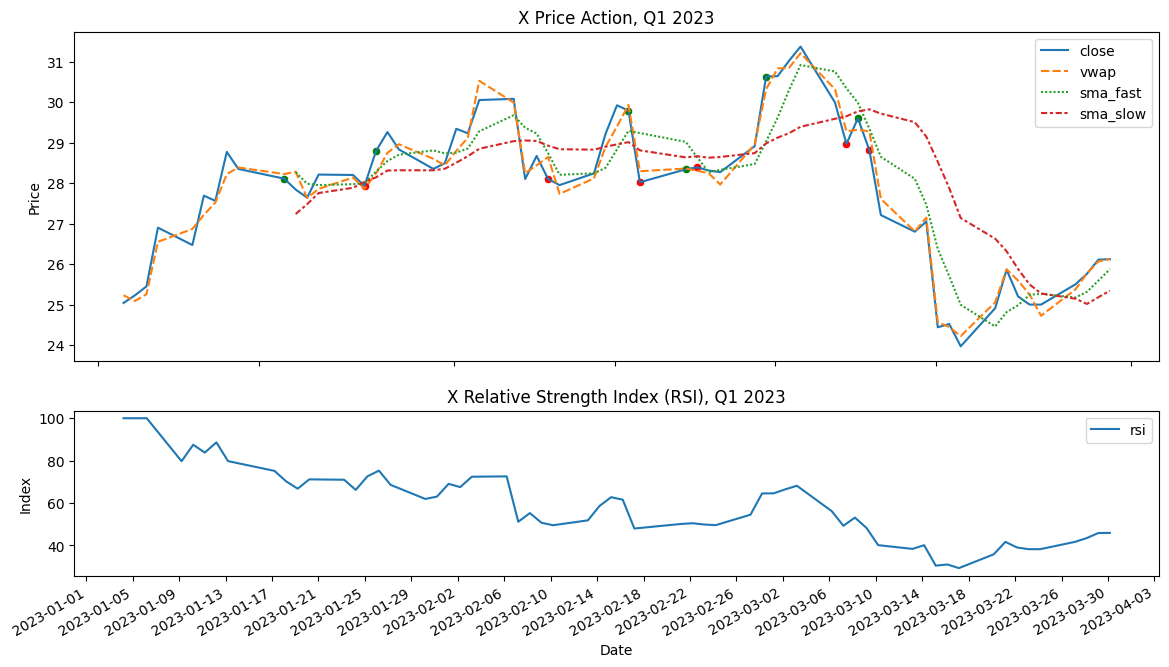

In [17]:
signals = signals.reset_index(level=['symbol']).drop('symbol', axis=1) # remove multi-index
fig, axs = matplot.subplots(2, 1, figsize=(14, 8), height_ratios=[2, 1])

seaborn.lineplot(data=pandas.concat([signals[['close', 'vwap']], signals[['sma_fast', 'sma_slow']][slow:]], axis=1), ax=axs[0]) # drop early SMAs to clean up chart
seaborn.scatterplot(data=signals[signals['entry_exit'] == -1.0], x='timestamp', y='close', color='r', ax=axs[0])
seaborn.scatterplot(data=signals[signals['entry_exit'] == 1.0], x='timestamp', y='close', color='g', ax=axs[0])
axs[0].set_title('X Price Action, Q1 2023')
axs[0].set_ylabel('Price')

# put RSI on second chart since it's not scaled to price
seaborn.lineplot(data=signals[['rsi']][1:], ax=axs[1]) # first record skipped for chart cleanup
axs[1].set_title('X Relative Strength Index (RSI), Q1 2023')
axs[1].set_ylabel('Index')

matplot.xlabel('Date')
matplot.gca().xaxis.set_major_locator(DayLocator(interval=4))
matplot.gcf().autofmt_xdate()
pass # the ketchup


### Backtesting

In [ ]:
# TBD